In [3]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    for i in range(len(gpu_devices)):
        tf.config.experimental.set_memory_growth(gpu_devices[i], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload

import datetime as dt
os.chdir("../from_config") ######!!!!!!
import dev.testtraindata as dl
graph_data=dl.graph_data

Notebook
GPU detected
Not notebook


In [4]:
os.chdir('../model_eval')
os.getcwd()

'C:\\Users\\chris\\Christian\\3YR-UNI\\Bachelor\\IceCube\\model_eval'

In [5]:
# with tf.device('/cpu:0'):
#     save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
#     model=tf.keras.models.load_model("trained_models/IceCube_neutrino/KHop_K[1,2]agmaxn_25_2htf2yxw", options=save_options)
# model.compile()
# batch_size=512
# # dataset=graph_data(test_steps=10, n_neighbors=25, restart=False, \
# #                                      transform_path='../db_files/dev_lvl7//transformers.pkl')
# # loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

OSError: SavedModel file does not exist at: trained_models/IceCube_neutrino/KHop_K[1,2]agmaxn_25_2htf2yxw/{saved_model.pbtxt|saved_model.pb}

In [6]:
with tf.device('/cpu:0'):
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model=tf.keras.models.load_model("../trained_models/KHop_base_max_3fsagz9i", options=save_options)
model.compile()
batch_size=512
# dataset=graph_data(test_steps=10, n_neighbors=25, restart=False, \
#                                      transform_path='../db_files/dev_lvl7//transformers.pkl')
# loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

In [15]:
os.chdir('..')
os.getcwd()
dataset=graph_data(n_steps=10, n_neighbors=30, restart=False, traintest='test', i_test=0)
loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)
os.chdir('model_eval')
os.getcwd()

Loading test data 0 to memory


'C:\\Users\\chris\\Christian\\3YR-UNI\\Bachelor\\icecube\\model_eval'

In [16]:
@tf.function(input_signature = loader.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 

    return predictions, targets

In [19]:
def predict(loader):
    prediction_list, target_list = [], []
    for batch in tqdm(loader, total=loader.steps_per_epoch):
        inputs, targets = batch
        predictions, targets = test_step(inputs, targets)

        prediction_list.append(predictions.numpy())
        target_list.append(targets.numpy())
        y_reco  = tf.concat(prediction_list, axis = 0).numpy()
        y_true  = tf.concat(target_list, axis = 0)
        y_true  = tf.cast(y_true, tf.float32).numpy()
    return y_reco, y_true

In [38]:
os.chdir('..')
recos=[]
trues=[]
for i in range(8):
    dataset=graph_data(n_steps=10, n_neighbors=30, restart=False, traintest='test', i_test=i)
    loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)
    reco, true=predict(loader)
    recos.append(reco)
    trues.append(true)
os.chdir('model_eval')

Loading test data 0 to memory



Loading test data 1 to memory



Loading test data 2 to memory



Loading test data 3 to memory



Loading test data 4 to memory



Loading test data 5 to memory



Loading test data 6 to memory



Loading test data 7 to memory


In [46]:
predckj=np.concatenate(recos)
trueckj=np.concatenate(trues)

In [60]:
predl=['energy_log10_pred', 'zenith_pred', 'azimuth_pred', 'zenith_kappa', 'azimuth_kappa']
truel=['energy_log10', 'zenith', 'azimuth', 'event_no']
dfckj=pd.DataFrame(np.hstack([trueckj,predckj]), columns=truel+predl)

In [54]:
# from scipy.special import iv
# ze_sigma = np.sqrt(1 - iv(1,np.square(reco[:,3]))/iv(0,np.square(reco[:,3])))*180/np.pi
# az_sigma = np.sqrt(1 - iv(1,np.square(reco[:,4]))/iv(0,np.square(reco[:,4]))*180/np.pi
zenimask=reco[:,3]>np.median(reco[:,3])
azimask=reco[:,4]>np.median(reco[:,4])
zenireco, zenitrue=reco[zenimask], true[zenimask]
azireco, azitrue=reco[azimask], true[azimask]
mask=np.logical_and(zenimask, azimask) 
reco1, true1=reco[mask], true[mask]

In [61]:
dfjv=pd.read_csv('../predictions/OscNext_ZeE_m21_2jj9_test_predictions.csv')

In [75]:
for df in [dfjv, dfckj]:
    for target in truel[:3]:
        if target+'_pred' in df.columns:
            df[target+'_res']=df[target]-df[target+'_pred']
    df=df.sort_values(by='event_no')

In [95]:
dfckj=dfckj.drop_duplicates(subset='event_no')
dfckj=dfckj.sort_values(by='event_no')

In [94]:
dfjv=dfjv[np.in1d(dfjv['event_no'], dfckj['event_no'])]

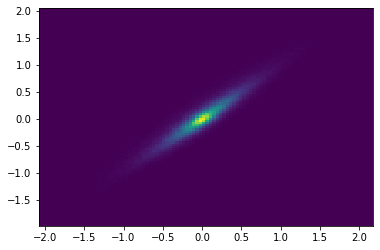

In [98]:
plt.hist2d(dfjv['zenith_res'], dfckj['zenith_res'], bins=100);

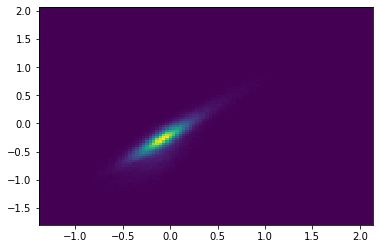

In [100]:
plt.hist2d(dfjv['energy_log10_res'], dfckj['energy_log10_res'], bins=100);

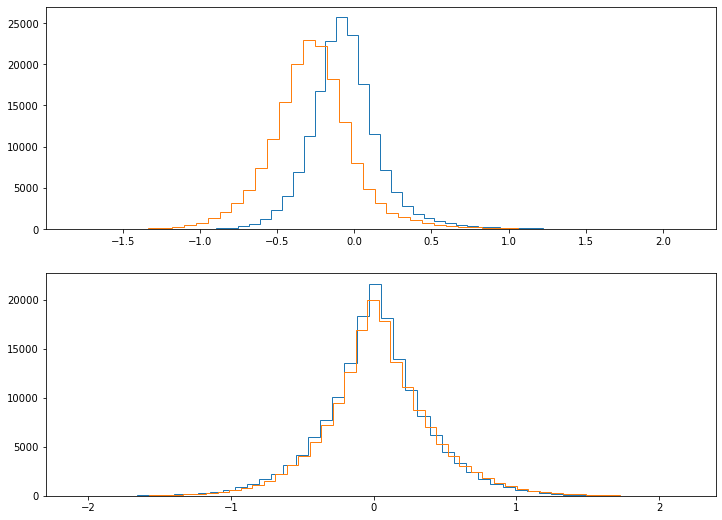

In [107]:
fig, ax=plt.subplots(2, figsize=(12,9))
bins=50
ax[0].hist(dfjv['energy_log10_res'], bins=bins, histtype='step')
ax[0].hist(dfckj['energy_log10_res'], bins=bins, histtype='step')
ax[1].hist(dfjv['zenith_res'], bins=bins, histtype='step')
ax[1].hist(dfckj['zenith_res'], bins=bins, histtype='step');

{'Old metrics:': ' ', 'E': 0.227, 'Omega': '46.989', 'Zeni': '19.298', 'Azi': '51.581'} {'E': '0.293, 0.109<->0.529', 'Omega': '31.666, 11.261<->70.109', 'Zeni': '11.920, 3.081<->30.008', 'Azi': '28.702, 6.508<->93.243'}


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


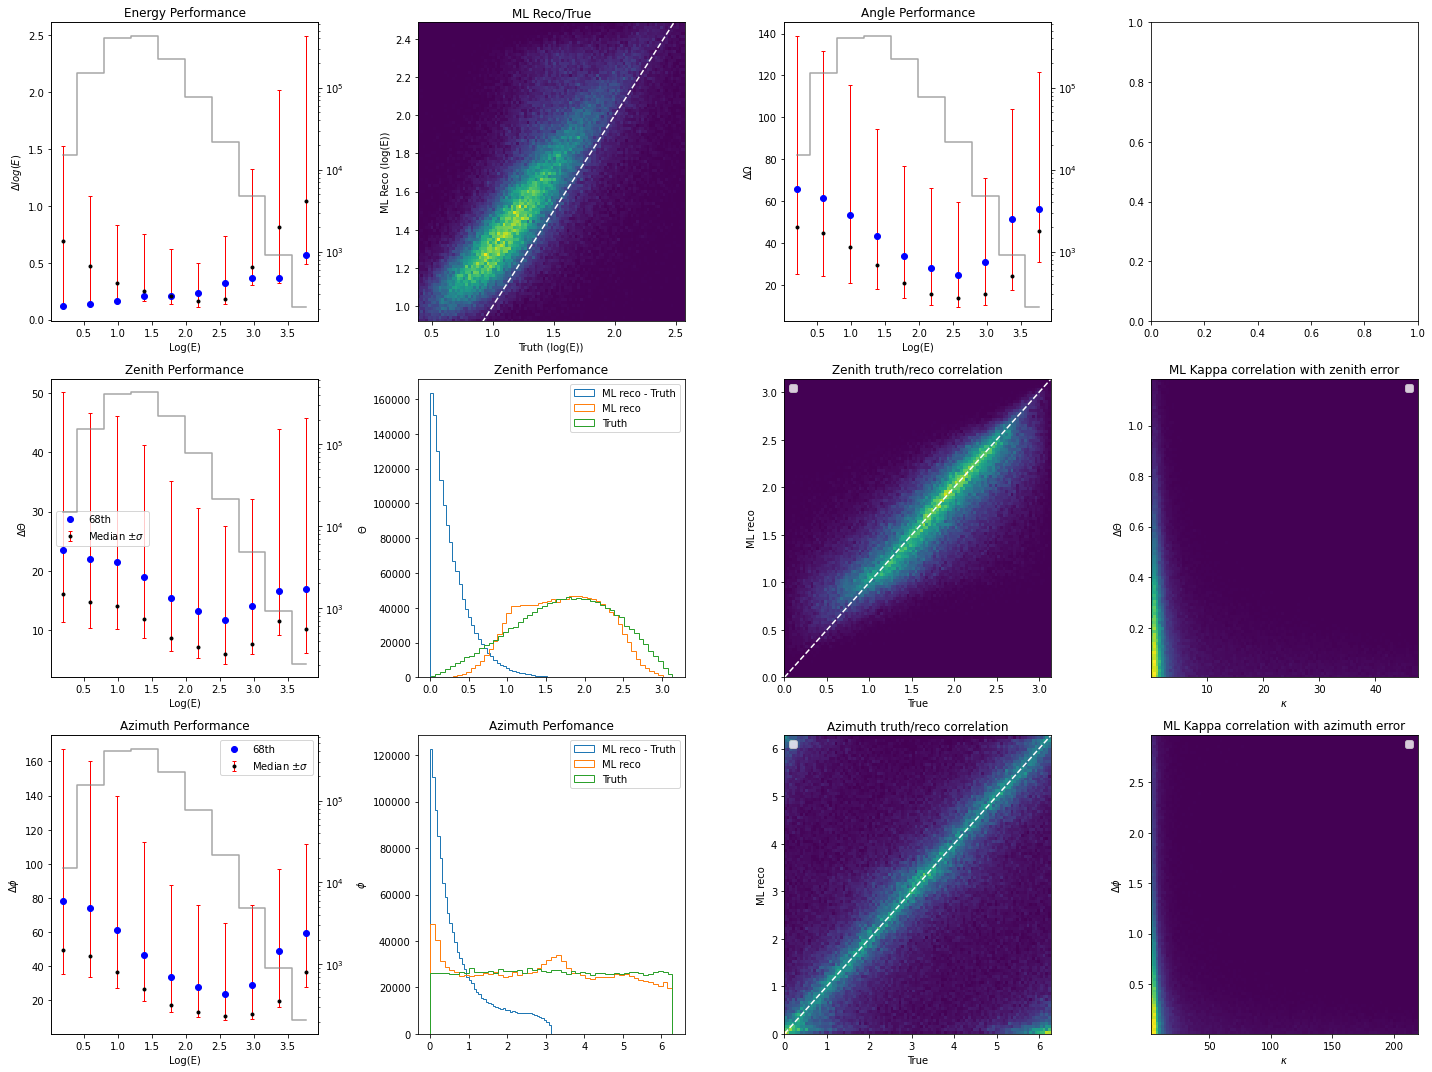

In [53]:
# os.chdir('../model_eval')
# os.getcwd()
import eval_plots as e
reload(e)
performance=e.performance_vM2D
# performance(reco1, true1);
performance(predckj, trueckj);

In [27]:
import pandas as pd
def get_event_no():
        print('Reading sets')
        sets = pd.read_pickle('../db_files/dev_lvl7/sets.pkl')
        train_events = sets['train']
        test_events = sets['test']
        return train_events['event_no'].to_numpy(), test_events['event_no'].to_numpy()

In [28]:
train_events, test_events=get_event_no()

Reading sets


In [31]:
ids=true[:,3]

In [32]:
np.in1d(ids, test_events)

100000